# This example uses data from the UCI Machine Learning Dataset Archive
## Abalone sex-typing is difficult to do (you need to cut into shells to counts rings like a tree)
### Instead of doing that manually, the dataset measures other physical characteristics & we will attempt to predict sex from those

Example: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone.html

Using: https://archive.ics.uci.edu/ml/datasets/abalone

In [1]:
import os
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3_client = boto3.client("s3")


# S3 bucket where the training data is located.
data_bucket = f"sagemaker-sample-files"
data_prefix = "datasets/tabular/uci_abalone"
data_bucket_path = f"s3://{data_bucket}"

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
output_bucket = sagemaker.Session().default_bucket()
output_prefix = "sagemaker/DEMO-xgboost-abalone-default"
output_bucket_path = f"s3://{output_bucket}"

for data_category in ["train", "test", "validation"]:
    data_key = "{0}/{1}/abalone.{1}".format(data_prefix, data_category)
    output_key = "{0}/{1}/abalone.{1}".format(output_prefix, data_category)
    data_filename = "abalone.{}".format(data_category)
    s3_client.download_file(data_bucket, data_key, data_filename)
    s3_client.upload_file(data_filename, output_bucket, output_key)

In [2]:
container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

In [3]:
import boto3
from time import gmtime, strftime

job_name = f"DEMO-xgboost-regression-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print("Training job", job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"{output_bucket_path}/{output_prefix}/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.2xlarge", "VolumeSizeInGB": 5},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "reg:linear",
        "num_round": "50",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{output_bucket_path}/{output_prefix}/train",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{output_bucket_path}/{output_prefix}/validation",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None",
        },
    ],
}


client = boto3.client("sagemaker", region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)

Training job DEMO-xgboost-regression-2021-05-12-07-45-10
InProgress
InProgress
InProgress
InProgress
Completed


In [4]:
import boto3
from time import gmtime, strftime

model_name = f"{job_name}-model"
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": container, "ModelDataUrl": model_data}

create_model_response = client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])


DEMO-xgboost-regression-2021-05-12-07-45-10-model
s3://sagemaker-us-east-1-297110193016/sagemaker/DEMO-xgboost-abalone-default/single-xgboost/DEMO-xgboost-regression-2021-05-12-07-45-10/output/model.tar.gz
arn:aws:sagemaker:us-east-1:297110193016:model/demo-xgboost-regression-2021-05-12-07-45-10-model


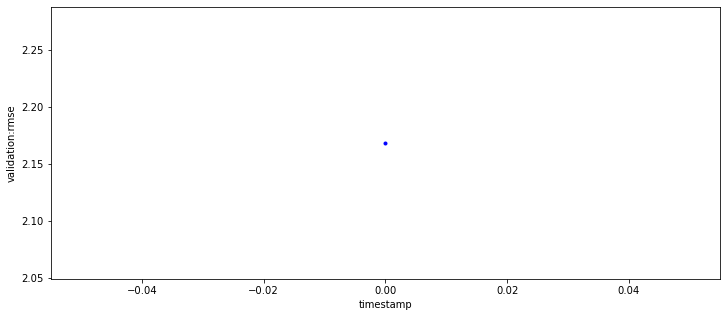

In [5]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = "validation:rmse"

metrics_dataframe = TrainingJobAnalytics(
    training_job_name=job_name, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    kind="line", figsize=(12, 5), x="timestamp", y="value", style="b.", legend=False
)
plt.set_ylabel(metric_name);

In [6]:
from time import gmtime, strftime

endpoint_config_name = f"DEMO-XGBoostEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

DEMO-XGBoostEndpointConfig-2021-05-12-07-49-12
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:297110193016:endpoint-config/demo-xgboostendpointconfig-2021-05-12-07-49-12


In [16]:
import time

endpoint_name = f'DEMO-XGBoostEndpoint-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Status: {status}")
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]

print(f"Arn: {resp['EndpointArn']}")
print(f"Status: {status}")

DEMO-XGBoostEndpoint-2021-05-12-08-03-02
arn:aws:sagemaker:us-east-1:297110193016:endpoint/demo-xgboostendpoint-2021-05-12-08-03-02
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:297110193016:endpoint/demo-xgboostendpoint-2021-05-12-08-03-02
Status: InService


In [17]:
runtime_client = boto3.client("runtime.sagemaker", region_name=region)

In [18]:
FILE_TEST = "abalone.test"
s3 = boto3.client("s3")
s3.download_file(data_bucket, f"{data_prefix}/test/{FILE_TEST}", FILE_TEST)

In [19]:
!head -1 abalone.test > abalone.single.test

In [20]:
import json
from itertools import islice
import math
import struct

file_name = "abalone.single.test"  # customize to your test file
with open(file_name, "r") as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="text/x-libsvm", Body=payload
)
result = response["Body"].read()
result = result.decode("utf-8")
result = result.split(",")
result = [math.ceil(float(i)) for i in result]
label = payload.strip(" ").split()[0]
print(f"Label: {label}\nPrediction: {result[0]}")

Label: 12
Prediction: 13


In [21]:
import sys
import math


def do_predict(data, endpoint_name, content_type):
    payload = "\n".join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=payload
    )
    result = response["Body"].read()
    result = result.decode("utf-8")
    result = result.split(",")
    preds = [float((num)) for num in result]
    preds = [math.ceil(num) for num in preds]
    return preds


def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []

    for offset in range(0, items, batch_size):
        if offset + batch_size < items:
            results = do_predict(data[offset : (offset + batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write(".")
    return arrs

In [22]:
import json
import numpy as np

with open(FILE_TEST, "r") as f:
    payload = f.read().strip()

labels = [int(line.split(" ")[0]) for line in payload.split("\n")]
test_data = [line for line in payload.split("\n")]
preds = batch_predict(test_data, 100, endpoint_name, "text/x-libsvm")

print(
    "\n Median Absolute Percent Error (MdAPE) = ",
    np.median(np.abs(np.array(labels) - np.array(preds)) / np.array(labels)),
)

.......
 Median Absolute Percent Error (MdAPE) =  0.14285714285714285


In [23]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '305757a6-c8f7-4005-ade7-adae158aaae9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '305757a6-c8f7-4005-ade7-adae158aaae9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 12 May 2021 08:11:03 GMT'},
  'RetryAttempts': 0}}